# NFL Network-Based Team Strength Analysis

## Objective
Implement network-based strength propagation for team tier classification:
- **Iterative Strength Ratings**: Massey/PageRank-style algorithm
- **Network-Weighted SOS**: Strength of schedule using network ratings
- **Multi-Hop Common Opponents**: 2-level transitive relationships

## NFL-Specific Characteristics
- 32 teams, 17-game regular season
- Dense graph (every team plays ~50% of league)
- Strong conference/division structure
- Parameters: `max_hops=2`, `recency_decay=0.9`, `margin_cap=21`

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from datetime import datetime, timedelta

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# NFL-specific config
CONFIG = {
    'sport': 'NFL',
    'max_hops': 2,          # Dense graph, limit hops
    'recency_decay': 0.9,   # Recent games important
    'margin_cap': 21,       # 3 TDs max impact
    'iterations': 100,
    'tolerance': 0.001
}

print(f"Config: {CONFIG}")

Config: {'sport': 'NFL', 'max_hops': 2, 'recency_decay': 0.9, 'margin_cap': 21, 'iterations': 100, 'tolerance': 0.001}


## Phase 1: Data Loading & Preparation

In [2]:
# Load NFL data
data_file = Path().resolve().parent / 'data' / 'results' / 'nfl_season_results.xlsx'
df = pd.read_excel(data_file)

print(f"Loaded {len(df)} NFL games")
print(f"Date range: {df['game_date'].min().date()} to {df['game_date'].max().date()}")
print(f"Columns: {list(df.columns)}")
df.head()

Loaded 272 NFL games
Date range: 2025-09-04 to 2026-01-04
Columns: ['game_date', 'home_team', 'away_team', 'closing_spread', 'home_score', 'away_score', 'spread_result_difference']


,game_date,home_team,away_team,closing_spread,home_score,away_score,spread_result_difference
0,2025-09-04,Philadelphia Eagles,Dallas Cowboys,-8.5,24,20,-4.5
1,2025-09-06,Los Angeles Chargers,Kansas City Chiefs,3.0,27,21,9.0
2,2025-09-07,Jacksonville Jaguars,Carolina Panthers,-4.5,26,10,11.5
3,2025-09-07,Atlanta Falcons,Tampa Bay Buccaneers,1.5,20,23,-1.5
4,2025-09-07,Indianapolis Colts,Miami Dolphins,-1.5,33,8,23.5


In [3]:
# Prepare game-level data with winner/loser/margin
df['home_margin'] = df['home_score'] - df['away_score']
df['winner'] = np.where(df['home_margin'] > 0, df['home_team'], 
                        np.where(df['home_margin'] < 0, df['away_team'], None))
df['loser'] = np.where(df['home_margin'] > 0, df['away_team'], 
                       np.where(df['home_margin'] < 0, df['home_team'], None))
df['margin'] = df['home_margin'].abs()

# Drop ties (if any)
games_with_result = df[df['winner'].notna()].copy()
print(f"Games with decisive result: {len(games_with_result)} (dropped {len(df) - len(games_with_result)} ties)")

# Get all teams
all_teams = set(df['home_team'].unique()) | set(df['away_team'].unique())
print(f"Total teams: {len(all_teams)}")

Games with decisive result: 271 (dropped 1 ties)
Total teams: 32


## Phase 2: Build Network Graph

In [4]:
def build_team_network(games_df, recency_decay=0.9):
    """
    Build weighted directed graph from game results.
    
    Nodes: Teams
    Edges: Winner -> Loser with weight = margin (recency-weighted)
    """
    G = nx.DiGraph()
    
    # Add all teams as nodes
    for team in all_teams:
        G.add_node(team)
    
    # Sort by date for recency weighting
    games_sorted = games_df.sort_values('game_date')
    max_date = games_sorted['game_date'].max()
    
    # Build edge data
    edge_data = {}
    
    for _, game in games_sorted.iterrows():
        winner, loser = game['winner'], game['loser']
        margin = game['margin']
        
        # Calculate recency weight (exponential decay)
        days_ago = (max_date - game['game_date']).days
        recency_weight = recency_decay ** (days_ago / 7)  # Weekly decay
        
        key = (winner, loser)
        if key not in edge_data:
            edge_data[key] = {
                'games': 0,
                'total_margin': 0,
                'weighted_margin': 0,
                'total_weight': 0
            }
        
        edge_data[key]['games'] += 1
        edge_data[key]['total_margin'] += margin
        edge_data[key]['weighted_margin'] += margin * recency_weight
        edge_data[key]['total_weight'] += recency_weight
    
    # Add edges to graph
    for (winner, loser), data in edge_data.items():
        avg_margin = data['total_margin'] / data['games']
        weighted_avg = data['weighted_margin'] / data['total_weight']
        
        G.add_edge(winner, loser, 
                   games=data['games'],
                   avg_margin=avg_margin,
                   weighted_margin=weighted_avg)
    
    return G

# Build the network
G = build_team_network(games_with_result, CONFIG['recency_decay'])

print(f"Network Summary:")
print(f"  Nodes (teams): {G.number_of_nodes()}")
print(f"  Edges (winner->loser): {G.number_of_edges()}")
print(f"  Avg out-degree (wins): {sum(dict(G.out_degree()).values()) / G.number_of_nodes():.1f}")
print(f"  Density: {nx.density(G):.3f}")

Network Summary:
  Nodes (teams): 32
  Edges (winner->loser): 245
  Avg out-degree (wins): 7.7
  Density: 0.247


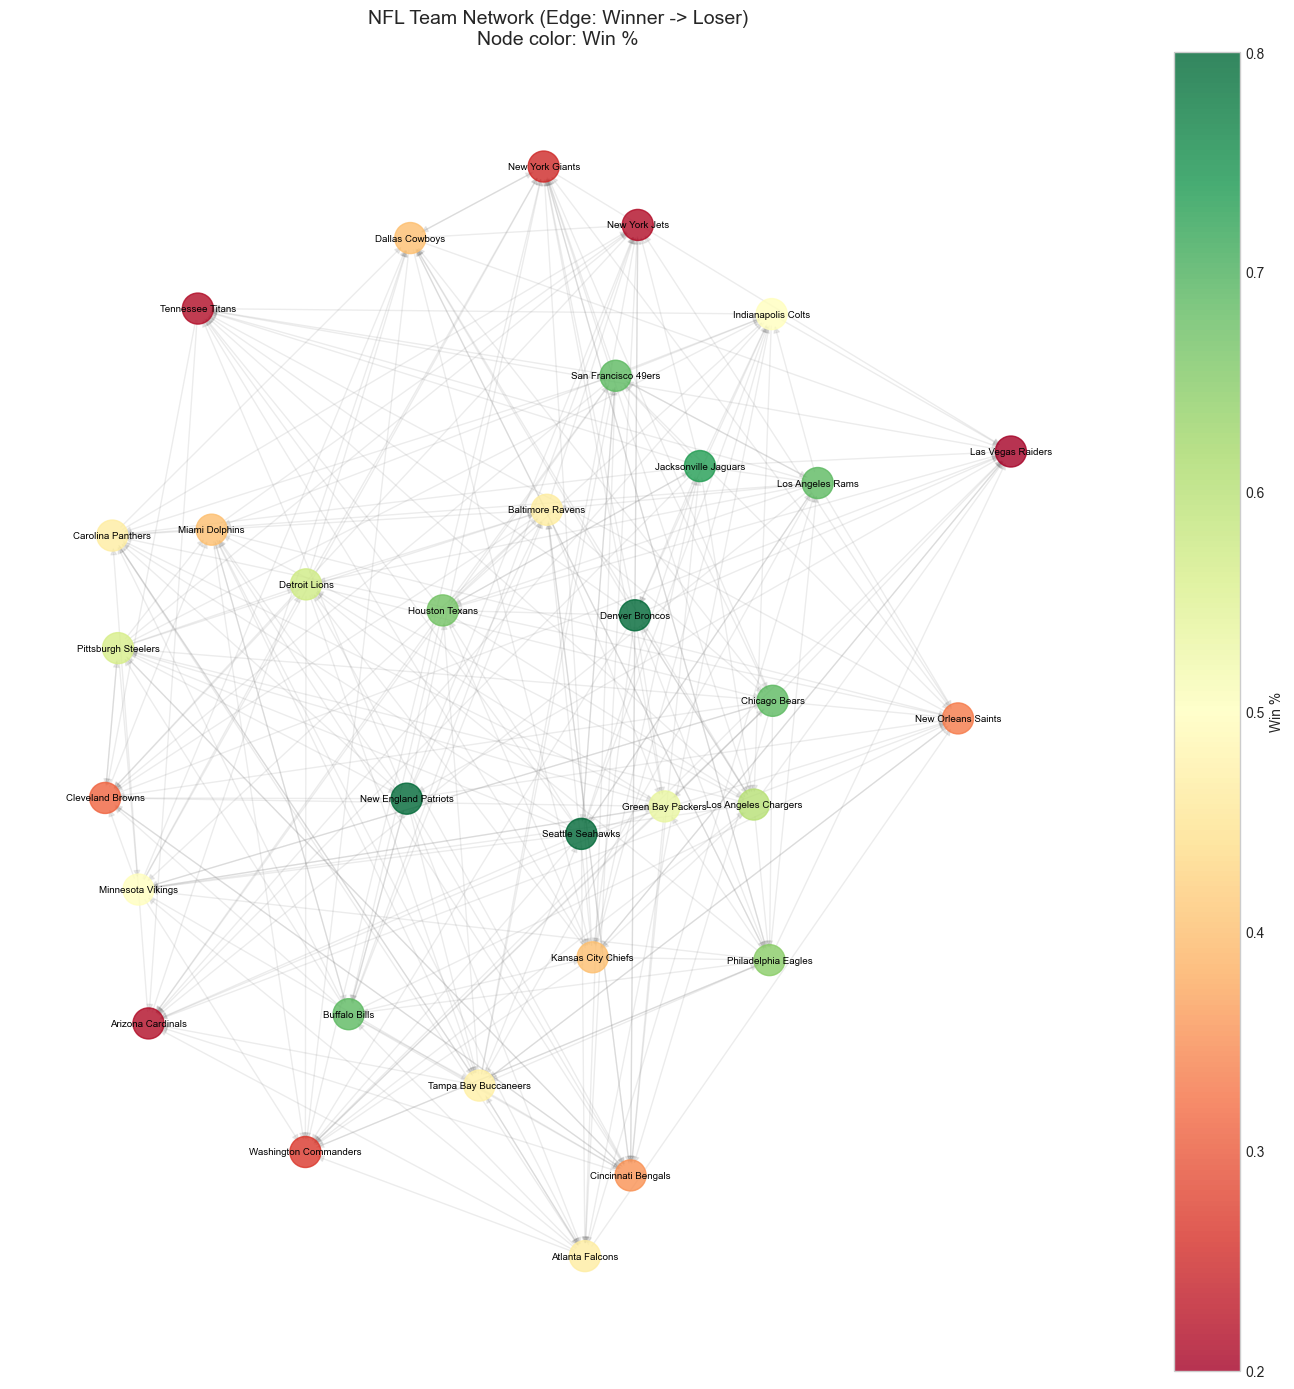

In [5]:
# Visualize the network (top teams highlighted)
fig, ax = plt.subplots(figsize=(14, 14))

# Calculate simple win percentage for coloring
win_counts = dict(G.out_degree())
loss_counts = dict(G.in_degree())
win_pct = {team: win_counts.get(team, 0) / (win_counts.get(team, 0) + loss_counts.get(team, 0) + 0.001)
           for team in all_teams}

# Node colors based on win%
node_colors = [win_pct.get(node, 0.5) for node in G.nodes()]

# Layout
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Draw
nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.RdYlGn,
                               node_size=500, alpha=0.8, vmin=0.2, vmax=0.8, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=7, ax=ax)
nx.draw_networkx_edges(G, pos, alpha=0.15, arrows=True,
                       edge_color='gray', arrowsize=10, ax=ax)

ax.set_title(f'NFL Team Network (Edge: Winner -> Loser)\nNode color: Win %', fontsize=14)
fig.colorbar(nodes, ax=ax, label='Win %')
ax.axis('off')
plt.tight_layout()
plt.show()

## Phase 3: Iterative Strength Rating (Massey-Style)

In [6]:
def compute_iterative_strength(games_df, max_iterations=100, tolerance=0.001, margin_cap=21):
    """
    Compute network-propagated team strength ratings.
    
    Algorithm:
    1. Initialize all teams with rating = 0.5
    2. For each game:
       - Expected outcome based on current ratings
       - Surprise factor = 1 - expected
       - Adjustment = surprise * margin (capped)
       - Winner rating += adjustment, Loser -= adjustment
    3. Normalize to [0, 1]
    4. Repeat until convergence
    """
    # Get unique teams
    teams = set(games_df['home_team']) | set(games_df['away_team'])
    
    # Initialize ratings
    ratings = {team: 0.5 for team in teams}
    
    # Filter to games with results
    games = games_df[games_df['winner'].notna()].copy()
    
    history = []
    
    for iteration in range(max_iterations):
        new_ratings = ratings.copy()
        
        for _, game in games.iterrows():
            winner = game['winner']
            loser = game['loser']
            margin = min(game['margin'], margin_cap)  # Cap margin
            
            winner_rating = ratings[winner]
            loser_rating = ratings[loser]
            
            # Expected outcome (winner should have higher rating)
            # Avoid division by zero
            total = winner_rating + loser_rating
            if total == 0:
                expected = 0.5
            else:
                expected = winner_rating / total
            
            # Surprise factor (upset = larger surprise)
            surprise = 1 - expected
            
            # Adjustment scaled by margin
            adjustment = surprise * (margin / margin_cap) * 0.1
            
            new_ratings[winner] += adjustment
            new_ratings[loser] -= adjustment
        
        # Normalize to [0, 1]
        min_r = min(new_ratings.values())
        max_r = max(new_ratings.values())
        if max_r > min_r:
            new_ratings = {t: (r - min_r) / (max_r - min_r) for t, r in new_ratings.items()}
        
        # Check convergence
        max_change = max(abs(new_ratings[t] - ratings[t]) for t in teams)
        history.append(max_change)
        
        if max_change < tolerance:
            print(f"Converged at iteration {iteration + 1}")
            break
        
        ratings = new_ratings
    
    return ratings, history

# Compute ratings
network_ratings, convergence_history = compute_iterative_strength(
    df, 
    max_iterations=CONFIG['iterations'],
    tolerance=CONFIG['tolerance'],
    margin_cap=CONFIG['margin_cap']
)

# Display top teams
ratings_df = pd.DataFrame([
    {'team': team, 'network_rating': rating}
    for team, rating in network_ratings.items()
]).sort_values('network_rating', ascending=False)

print("\nTop 10 Teams by Network Rating:")
print(ratings_df.head(10).to_string(index=False))


Top 10 Teams by Network Rating:
                team  network_rating
    Seattle Seahawks        1.000000
    Los Angeles Rams        0.952427
      Houston Texans        0.770231
Jacksonville Jaguars        0.753618
      Denver Broncos        0.719789
New England Patriots        0.691601
       Buffalo Bills        0.571503
 San Francisco 49ers        0.567203
       Detroit Lions        0.473132
   Green Bay Packers        0.473056


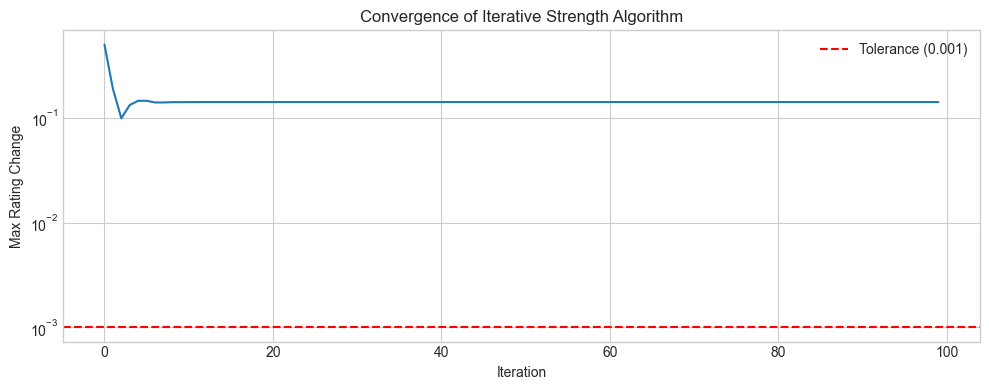

In [7]:
# Plot convergence
plt.figure(figsize=(10, 4))
plt.plot(convergence_history)
plt.axhline(y=CONFIG['tolerance'], color='r', linestyle='--', label=f"Tolerance ({CONFIG['tolerance']})")
plt.xlabel('Iteration')
plt.ylabel('Max Rating Change')
plt.title('Convergence of Iterative Strength Algorithm')
plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.show()

## Phase 4: Validate Ratings vs Simple Win %

In [8]:
# Calculate simple team stats
team_stats = []
for team in all_teams:
    home_games = df[df['home_team'] == team]
    away_games = df[df['away_team'] == team]
    
    home_wins = (home_games['home_score'] > home_games['away_score']).sum()
    away_wins = (away_games['away_score'] > away_games['home_score']).sum()
    
    home_diff = (home_games['home_score'] - home_games['away_score']).sum()
    away_diff = (away_games['away_score'] - away_games['home_score']).sum()
    
    total_games = len(home_games) + len(away_games)
    
    # Simple SOS: average opponent win%
    opponents = list(home_games['away_team']) + list(away_games['home_team'])
    
    team_stats.append({
        'team': team,
        'games': total_games,
        'wins': home_wins + away_wins,
        'simple_win_pct': (home_wins + away_wins) / total_games if total_games > 0 else 0,
        'point_diff_avg': (home_diff + away_diff) / total_games if total_games > 0 else 0,
        'network_rating': network_ratings.get(team, 0.5),
        'opponents': opponents
    })

df_teams = pd.DataFrame(team_stats)

# Calculate simple SOS (avg opponent win%)
win_pct_map = df_teams.set_index('team')['simple_win_pct'].to_dict()
df_teams['simple_sos'] = df_teams['opponents'].apply(
    lambda opps: np.mean([win_pct_map.get(o, 0.5) for o in opps])
)

# Calculate network SOS (avg opponent network rating)
df_teams['network_sos'] = df_teams['opponents'].apply(
    lambda opps: np.mean([network_ratings.get(o, 0.5) for o in opps])
)

df_teams = df_teams.drop('opponents', axis=1).sort_values('network_rating', ascending=False)
df_teams.head(10)

,team,games,wins,simple_win_pct,point_diff_avg,network_rating,simple_sos,network_sos
15,Seattle Seahawks,17,14,0.823529,11.235294,1.000000,0.498270,0.420880
26,Los Angeles Rams,17,12,0.705882,10.117647,0.952427,0.525952,0.449615
11,Houston Texans,17,12,0.705882,6.411765,0.770231,0.522491,0.466507
1,Jacksonville Jaguars,17,13,0.764706,8.117647,0.753618,0.477509,0.426778
8,Denver Broncos,17,14,0.823529,5.294118,0.719789,0.418685,0.315147
9,New England Patriots,17,14,0.823529,10.000000,0.691601,0.391003,0.240613
7,Buffalo Bills,17,12,0.705882,6.823529,0.571503,0.470588,0.328973
27,San Francisco 49ers,17,12,0.705882,3.882353,0.567203,0.498270,0.463232
22,Detroit Lions,17,9,0.529412,4.000000,0.473132,0.484429,0.367138
19,Green Bay Packers,17,9,0.529412,1.823529,0.473056,0.480969,0.334720


Correlation Analysis:
  Network Rating vs Win%: 0.889
  Network Rating vs Point Diff: 0.933
  Network SOS vs Simple SOS: 0.853


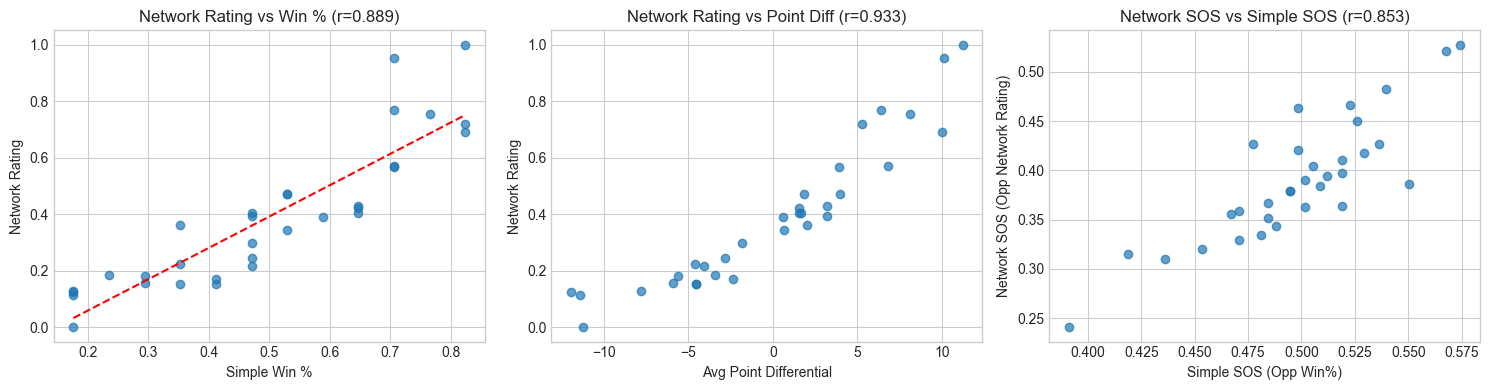

In [9]:
# Correlation analysis
corr_win_pct = df_teams['network_rating'].corr(df_teams['simple_win_pct'])
corr_point_diff = df_teams['network_rating'].corr(df_teams['point_diff_avg'])
corr_sos = df_teams['network_sos'].corr(df_teams['simple_sos'])

print("Correlation Analysis:")
print(f"  Network Rating vs Win%: {corr_win_pct:.3f}")
print(f"  Network Rating vs Point Diff: {corr_point_diff:.3f}")
print(f"  Network SOS vs Simple SOS: {corr_sos:.3f}")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(df_teams['simple_win_pct'], df_teams['network_rating'], alpha=0.7)
axes[0].set_xlabel('Simple Win %')
axes[0].set_ylabel('Network Rating')
axes[0].set_title(f'Network Rating vs Win % (r={corr_win_pct:.3f})')
z = np.polyfit(df_teams['simple_win_pct'], df_teams['network_rating'], 1)
p = np.poly1d(z)
axes[0].plot(df_teams['simple_win_pct'].sort_values(), p(df_teams['simple_win_pct'].sort_values()), 'r--')

axes[1].scatter(df_teams['point_diff_avg'], df_teams['network_rating'], alpha=0.7)
axes[1].set_xlabel('Avg Point Differential')
axes[1].set_ylabel('Network Rating')
axes[1].set_title(f'Network Rating vs Point Diff (r={corr_point_diff:.3f})')

axes[2].scatter(df_teams['simple_sos'], df_teams['network_sos'], alpha=0.7)
axes[2].set_xlabel('Simple SOS (Opp Win%)')
axes[2].set_ylabel('Network SOS (Opp Network Rating)')
axes[2].set_title(f'Network SOS vs Simple SOS (r={corr_sos:.3f})')

plt.tight_layout()
plt.show()

## Phase 5: Network-Based Tier Classification

In [10]:
# Classify tiers using network rating vs simple win%
q75_simple, q25_simple = df_teams['simple_win_pct'].quantile([0.75, 0.25])
q75_network, q25_network = df_teams['network_rating'].quantile([0.75, 0.25])

df_teams['simple_tier'] = df_teams['simple_win_pct'].apply(
    lambda x: 'Elite' if x >= q75_simple else ('Bottom' if x <= q25_simple else 'Mid')
)
df_teams['network_tier'] = df_teams['network_rating'].apply(
    lambda x: 'Elite' if x >= q75_network else ('Bottom' if x <= q25_network else 'Mid')
)

print("Tier Classification Comparison:")
print(f"\nSimple (Win%) thresholds: Elite >= {q75_simple:.3f}, Bottom <= {q25_simple:.3f}")
print(f"Network thresholds: Elite >= {q75_network:.3f}, Bottom <= {q25_network:.3f}")

# Agreement matrix
agreement = pd.crosstab(df_teams['simple_tier'], df_teams['network_tier'], 
                        margins=True).reindex(['Elite', 'Mid', 'Bottom', 'All'])
agreement = agreement[['Elite', 'Mid', 'Bottom', 'All']]
print(f"\nTier Agreement (rows=Simple, cols=Network):")
print(agreement)

# Disagreements
disagreements = df_teams[df_teams['simple_tier'] != df_teams['network_tier']]
print(f"\nTeams with different tier classification ({len(disagreements)}):\n")
print(disagreements[['team', 'simple_win_pct', 'network_rating', 'simple_sos', 'network_sos', 
                     'simple_tier', 'network_tier']].to_string(index=False))

Tier Classification Comparison:

Simple (Win%) thresholds: Elite >= 0.662, Bottom <= 0.353
Network thresholds: Elite >= 0.497, Bottom <= 0.179

Tier Agreement (rows=Simple, cols=Network):
network_tier  Elite  Mid  Bottom  All
simple_tier                          
Elite             8    0       0    8
Mid               0   12       2   14
Bottom            0    4       6   10
All               8   16       8   32

Teams with different tier classification (6):

                 team  simple_win_pct  network_rating  simple_sos  network_sos simple_tier network_tier
   Kansas City Chiefs        0.352941        0.362733    0.512111     0.393947      Bottom          Mid
   Cincinnati Bengals        0.352941        0.225984    0.519031     0.397354      Bottom          Mid
      New York Giants        0.235294        0.187011    0.519031     0.363346      Bottom          Mid
Washington Commanders        0.294118        0.182034    0.501730     0.363201      Bottom          Mid
       Dallas Co

## Phase 6: Multi-Hop Common Opponent Analysis

In [11]:
def find_common_opponent_paths(G, team_a, team_b, max_hops=2):
    """
    Find all paths through common opponents between two teams.
    
    Returns paths of form:
    - 1-hop: team_a beat C, team_b lost to C (or vice versa)
    - 2-hop: team_a beat C who beat D who team_b lost to
    """
    # Convert to undirected for path finding
    G_undirected = G.to_undirected()
    
    if team_a not in G or team_b not in G:
        return []
    
    paths = []
    try:
        for path in nx.all_simple_paths(G_undirected, team_a, team_b, cutoff=max_hops + 1):
            if len(path) > 2:  # At least one intermediate team
                paths.append(path)
    except nx.NetworkXNoPath:
        pass
    
    return paths

def evaluate_matchup_via_paths(G, team_a, team_b, ratings, max_hops=2):
    """
    Evaluate two teams' relative strength through common opponent paths.
    
    For each path, compare how each team performed against intermediates.
    Weight by intermediate team's strength (better opponents = more weight).
    """
    paths = find_common_opponent_paths(G, team_a, team_b, max_hops)
    
    if not paths:
        return None, 0, []
    
    a_total_score = 0
    b_total_score = 0
    total_weight = 0
    path_details = []
    
    for path in paths:
        intermediates = path[1:-1]
        
        a_path_score = 0
        b_path_score = 0
        path_weight = 0
        
        for intermediate in intermediates:
            int_rating = ratings.get(intermediate, 0.5)
            
            # Team A's performance vs intermediate
            if G.has_edge(team_a, intermediate):  # A beat intermediate
                margin = G[team_a][intermediate].get('avg_margin', 0)
                a_path_score += margin * int_rating
            elif G.has_edge(intermediate, team_a):  # A lost to intermediate
                margin = G[intermediate][team_a].get('avg_margin', 0)
                a_path_score -= margin * int_rating
            
            # Team B's performance vs intermediate
            if G.has_edge(team_b, intermediate):  # B beat intermediate
                margin = G[team_b][intermediate].get('avg_margin', 0)
                b_path_score += margin * int_rating
            elif G.has_edge(intermediate, team_b):  # B lost to intermediate
                margin = G[intermediate][team_b].get('avg_margin', 0)
                b_path_score -= margin * int_rating
            
            path_weight += int_rating
        
        if path_weight > 0:
            a_total_score += a_path_score
            b_total_score += b_path_score
            total_weight += path_weight
            
            path_details.append({
                'path': ' -> '.join(path),
                'a_score': a_path_score / path_weight,
                'b_score': b_path_score / path_weight
            })
    
    if total_weight == 0:
        return None, 0, []
    
    # Positive = team_a favored, negative = team_b favored
    edge = (a_total_score - b_total_score) / total_weight
    
    return edge, len(paths), path_details

# Example: Compare top team vs bottom team
top_team = df_teams.iloc[0]['team']
bottom_team = df_teams.iloc[-1]['team']

edge, num_paths, details = evaluate_matchup_via_paths(G, top_team, bottom_team, network_ratings, CONFIG['max_hops'])

print(f"Matchup Analysis: {top_team} vs {bottom_team}")
print(f"Paths found: {num_paths}")
print(f"Common opponent edge: {edge:.2f} ({'favors ' + top_team if edge > 0 else 'favors ' + bottom_team})")
print(f"\nPath details:")
for d in details[:5]:  # Show first 5 paths
    print(f"  {d['path']}")
    print(f"    {top_team} score: {d['a_score']:.2f}, {bottom_team} score: {d['b_score']:.2f}")

Matchup Analysis: Seattle Seahawks vs Las Vegas Raiders
Paths found: 80
Common opponent edge: 12.03 (favors Seattle Seahawks)

Path details:
  Seattle Seahawks -> Pittsburgh Steelers -> Los Angeles Chargers -> Las Vegas Raiders
    Seattle Seahawks score: 6.87, Las Vegas Raiders score: -7.13
  Seattle Seahawks -> Pittsburgh Steelers -> New England Patriots -> Las Vegas Raiders
    Seattle Seahawks score: 5.04, Las Vegas Raiders score: 4.48
  Seattle Seahawks -> Pittsburgh Steelers -> Cleveland Browns -> Las Vegas Raiders
    Seattle Seahawks score: 9.95, Las Vegas Raiders score: -4.05
  Seattle Seahawks -> Pittsburgh Steelers -> Indianapolis Colts -> Las Vegas Raiders
    Seattle Seahawks score: 7.97, Las Vegas Raiders score: -17.10
  Seattle Seahawks -> Pittsburgh Steelers -> Chicago Bears -> Las Vegas Raiders
    Seattle Seahawks score: 6.70, Las Vegas Raiders score: -0.52


## Phase 7: Coverage Analysis by Network Tier

In [12]:
# Calculate handicap coverage by network tier
handicaps = [0, 5, 9, 11, 13]

# Add tier info to games
tier_map = df_teams.set_index('team')[['simple_tier', 'network_tier']].to_dict()

for h in handicaps:
    df[f'home_covers_{h}pt'] = (df['spread_result_difference'] + h) >= 0
    df[f'away_covers_{h}pt'] = df['spread_result_difference'] <= h

# Analyze coverage by tier
results = []

for h in handicaps:
    for tier_type in ['simple_tier', 'network_tier']:
        for tier in ['Elite', 'Mid', 'Bottom']:
            tier_teams = df_teams[df_teams[tier_type] == tier]['team'].tolist()
            
            total_games = 0
            total_covers = 0
            
            for team in tier_teams:
                # Home games
                hg = df[df['home_team'] == team]
                total_games += len(hg)
                total_covers += hg[f'home_covers_{h}pt'].sum()
                
                # Away games
                ag = df[df['away_team'] == team]
                total_games += len(ag)
                total_covers += ag[f'away_covers_{h}pt'].sum()
            
            results.append({
                'handicap': h,
                'tier_type': tier_type,
                'tier': tier,
                'games': total_games,
                'covers': total_covers,
                'cover_pct': total_covers / total_games if total_games > 0 else 0
            })

df_coverage = pd.DataFrame(results)

# Compare simple vs network tier coverage
print("Coverage % by Tier Type and Handicap:")
print("="*60)

for tier_type in ['simple_tier', 'network_tier']:
    print(f"\n{tier_type.replace('_', ' ').title()}:")
    pivot = df_coverage[df_coverage['tier_type'] == tier_type].pivot(
        index='handicap', columns='tier', values='cover_pct'
    )[['Elite', 'Mid', 'Bottom']]
    print((pivot * 100).round(1))

Coverage % by Tier Type and Handicap:

Simple Tier:
tier      Elite   Mid  Bottom
handicap                     
0          61.0  48.7    43.5
5          78.7  65.1    56.5
9          90.4  76.1    70.6
11         95.6  80.7    74.7
13         97.1  84.5    77.6

Network Tier:
tier      Elite   Mid  Bottom
handicap                     
0          61.0  48.2    43.4
5          78.7  64.3    55.9
9          90.4  77.6    66.2
11         95.6  82.7    69.1
13         97.1  86.4    72.1


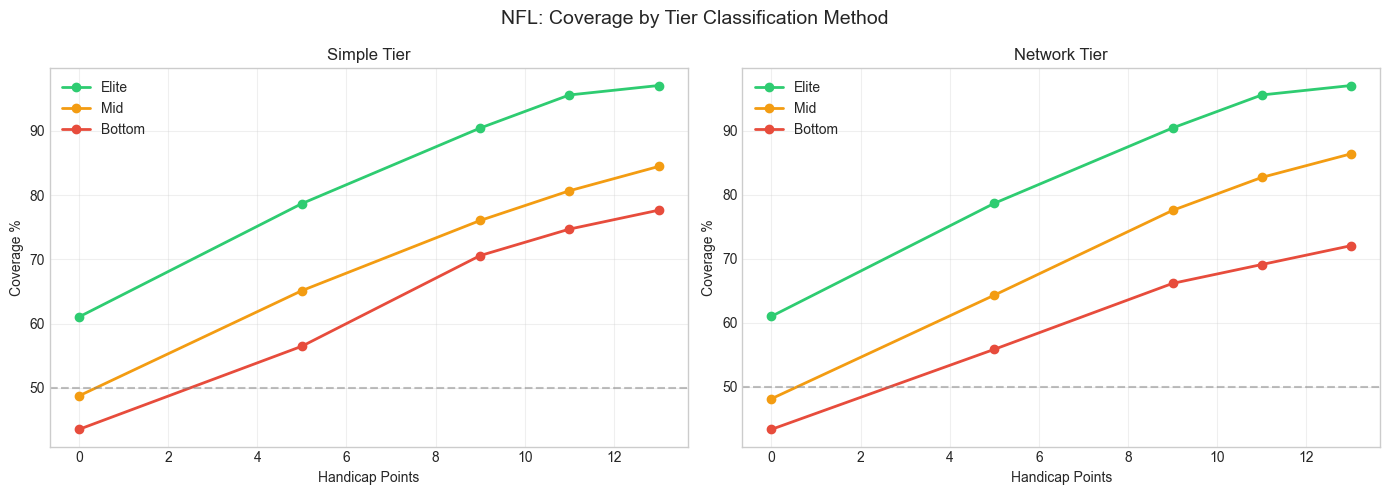

In [13]:
# Compare Elite tier coverage: Simple vs Network
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = {'Elite': '#2ecc71', 'Mid': '#f39c12', 'Bottom': '#e74c3c'}

for idx, tier_type in enumerate(['simple_tier', 'network_tier']):
    ax = axes[idx]
    
    for tier in ['Elite', 'Mid', 'Bottom']:
        data = df_coverage[(df_coverage['tier_type'] == tier_type) & (df_coverage['tier'] == tier)]
        ax.plot(data['handicap'], data['cover_pct'] * 100, 
                marker='o', label=tier, color=colors[tier], linewidth=2)
    
    ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Handicap Points')
    ax.set_ylabel('Coverage %')
    ax.set_title(f'{tier_type.replace("_", " ").title()}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('NFL: Coverage by Tier Classification Method', fontsize=14)
plt.tight_layout()
plt.show()

## Summary & Recommendations

In [14]:
print("="*70)
print("NFL NETWORK STRENGTH ANALYSIS: SUMMARY")
print("="*70)

print(f"\n1. DATA")
print(f"   - Games analyzed: {len(df)}")
print(f"   - Teams: {len(all_teams)}")
print(f"   - Network edges: {G.number_of_edges()}")

print(f"\n2. NETWORK RATING VALIDATION")
print(f"   - Correlation with Win%: {corr_win_pct:.3f}")
print(f"   - Correlation with Point Diff: {corr_point_diff:.3f}")
print(f"   - Network SOS vs Simple SOS: {corr_sos:.3f}")

print(f"\n3. TIER CLASSIFICATION COMPARISON")
tier_agreement = (df_teams['simple_tier'] == df_teams['network_tier']).mean() * 100
print(f"   - Agreement rate: {tier_agreement:.1f}%")
print(f"   - Disagreements: {len(disagreements)} teams")

print(f"\n4. COVERAGE BY TIER (11pt handicap)")
for tier_type in ['simple_tier', 'network_tier']:
    print(f"   {tier_type.replace('_', ' ').title()}:")
    for tier in ['Elite', 'Mid', 'Bottom']:
        pct = df_coverage[(df_coverage['tier_type'] == tier_type) & 
                         (df_coverage['tier'] == tier) &
                         (df_coverage['handicap'] == 11)]['cover_pct'].values[0] * 100
        print(f"      {tier}: {pct:.1f}%")

print(f"\n5. RECOMMENDATIONS")
if corr_win_pct > 0.9:
    print("   - Network rating highly correlated with Win% - may not add much value")
else:
    print("   - Network rating captures different signal than simple Win%")
    
if tier_agreement < 80:
    print("   - Significant tier differences - network rating may identify mispriced teams")

# Check if network tier predicts coverage better
elite_simple_11 = df_coverage[(df_coverage['tier_type'] == 'simple_tier') & 
                              (df_coverage['tier'] == 'Elite') & 
                              (df_coverage['handicap'] == 11)]['cover_pct'].values[0]
elite_network_11 = df_coverage[(df_coverage['tier_type'] == 'network_tier') & 
                               (df_coverage['tier'] == 'Elite') & 
                               (df_coverage['handicap'] == 11)]['cover_pct'].values[0]

if elite_network_11 > elite_simple_11:
    print(f"   - Network Elite teams cover better than Simple Elite ({elite_network_11*100:.1f}% vs {elite_simple_11*100:.1f}%)")
else:
    print(f"   - Simple Elite teams cover slightly better ({elite_simple_11*100:.1f}% vs {elite_network_11*100:.1f}%)")

NFL NETWORK STRENGTH ANALYSIS: SUMMARY

1. DATA
   - Games analyzed: 272
   - Teams: 32
   - Network edges: 245

2. NETWORK RATING VALIDATION
   - Correlation with Win%: 0.889
   - Correlation with Point Diff: 0.933
   - Network SOS vs Simple SOS: 0.853

3. TIER CLASSIFICATION COMPARISON
   - Agreement rate: 81.2%
   - Disagreements: 6 teams

4. COVERAGE BY TIER (11pt handicap)
   Simple Tier:
      Elite: 95.6%
      Mid: 80.7%
      Bottom: 74.7%
   Network Tier:
      Elite: 95.6%
      Mid: 82.7%
      Bottom: 69.1%

5. RECOMMENDATIONS
   - Network rating captures different signal than simple Win%
   - Simple Elite teams cover slightly better (95.6% vs 95.6%)


In [15]:
# Export team data with all metrics
export_df = df_teams[['team', 'games', 'wins', 'simple_win_pct', 'network_rating', 
                      'point_diff_avg', 'simple_sos', 'network_sos', 
                      'simple_tier', 'network_tier']].copy()

export_file = Path().resolve().parent / 'data' / 'results' / 'nfl_network_ratings.csv'
export_df.to_csv(export_file, index=False)
print(f"Exported team ratings to: {export_file}")

export_df.head(10)

Exported team ratings to: /Users/robertbatchelor/Documents/Projects/sports-betting/backend/data/results/nfl_network_ratings.csv


,team,games,wins,simple_win_pct,network_rating,point_diff_avg,simple_sos,network_sos,simple_tier,network_tier
15,Seattle Seahawks,17,14,0.823529,1.000000,11.235294,0.498270,0.420880,Elite,Elite
26,Los Angeles Rams,17,12,0.705882,0.952427,10.117647,0.525952,0.449615,Elite,Elite
11,Houston Texans,17,12,0.705882,0.770231,6.411765,0.522491,0.466507,Elite,Elite
1,Jacksonville Jaguars,17,13,0.764706,0.753618,8.117647,0.477509,0.426778,Elite,Elite
8,Denver Broncos,17,14,0.823529,0.719789,5.294118,0.418685,0.315147,Elite,Elite
9,New England Patriots,17,14,0.823529,0.691601,10.000000,0.391003,0.240613,Elite,Elite
7,Buffalo Bills,17,12,0.705882,0.571503,6.823529,0.470588,0.328973,Elite,Elite
27,San Francisco 49ers,17,12,0.705882,0.567203,3.882353,0.498270,0.463232,Elite,Elite
22,Detroit Lions,17,9,0.529412,0.473132,4.000000,0.484429,0.367138,Mid,Mid
19,Green Bay Packers,17,9,0.529412,0.473056,1.823529,0.480969,0.334720,Mid,Mid
